# Amazon Fine Food_Navie Bayes

# 1 Data Loading and Preprocessing

# 1.1 Loading the data

In [39]:
 %matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

con = sqlite3.connect('database.sqlite') #loading data

#filtering only positive and negative reviews
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# renaming the score with less than 3 to negative and more than 3 to positive
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

print("number of attributes and size of the data is")
print(filtered_data.shape) #number of attributes and size of the data
filtered_data.head() # prints first few rows

number of attributes and size of the data is
(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Time Based Splitting 

In [40]:
sorted_values = filtered_data.sort_values('Time',kind = 'quicksort')
final = sorted_values.drop_duplicates(subset= { 'UserId', 'ProfileName', 'Time',  'Text'})
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
#data_pos = final[final["Score"] == "positive"].sample(n = 25000)
#data_neg = final[final["Score"] == "negative"].sample(n = 25000)
#final = pd.concat([data_pos, data_neg])
print(final.shape)
print(final['Score'].value_counts())

(364171, 10)
positive    307061
negative     57110
Name: Score, dtype: int64


# 1.2 Preprocessing

In [41]:
import nltk
from nltk.stem import SnowballStemmer
import re
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

#function to remove html tagged words
def removehtml(sentence): 
    remove = re.compile('<.*?>')
    removetext = re.sub(remove, ' ', sentence)
    return removetext

#function to remove word of any pinctuation and special characters
def removepunct(sentence): 
    removed = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    removed = re.sub(r'[.|,|)|(|\|/]',r' ',removed)
    return  removed

print("Stop words found in the given dataset are:")
print(stop)

Stop words found in the given dataset are:
{'after', 'our', 'than', 'has', 'didn', 'such', 'ain', 'won', 'needn', 'been', "haven't", 'whom', 'once', 'weren', 'do', 'her', "couldn't", 've', 're', "hadn't", 'wouldn', 'with', 'couldn', 'before', 'itself', 'own', 'here', 'because', 'some', "it's", 'at', 'that', 'having', 'most', 'through', 'as', 'what', 'an', 'have', "isn't", 'just', "won't", 'all', 'further', 'up', 'no', 'a', 'under', 'isn', 't', 'hadn', 'i', "she's", "doesn't", 'she', 'below', 'for', 'herself', 'haven', "weren't", 'so', 'did', 'and', 'being', 'where', 'shouldn', 'o', "should've", 'both', 'but', 'aren', 'my', 'yourselves', "hasn't", 'on', 'more', "you've", 'against', 'me', 'until', 'there', "mightn't", 'when', "you'd", 'hasn', 'are', 'his', 'will', "wasn't", 'its', 'who', 'were', 'of', 'am', "that'll", 'while', 'into', 'in', 'down', 'doesn', "aren't", 'above', 'y', 'don', 'should', 'out', 'ourselves', 'too', 'd', 'by', 'be', 'now', 'off', "you'll", "wouldn't", 'nor', 'you

In [42]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=removehtml(sent) # calling function to remove HTMl tags
    for w in sent.split():
        for cleaned_words in removepunct(w).split(): #calling the function to remove punctuations and special characters and then split sentences into words 
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1

In [43]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

# 2 Function for Navie Bayes using Bernoullie NB

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
def run_NB(X_Train,y_train):
    global Final_Metrics
    cv_scores = []
    k_value = []
    Train_Scores = []
    Test_Scores = []
    algo = 'Naive Bayes'
    j=0    
    for i in range(2,30,2):
        nb = BernoulliNB(alpha=i)
        scores = cross_val_score(nb, X_Train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())
        k_value.append(i)
        print('For Alpha = ', i,'Accuracy Score = ', cv_scores[j]) 
        j+=1
    alpha_optimum = k_value[cv_scores.index(max(cv_scores))]
    plt.plot(k_value,cv_scores,'-o')
    plt.xlabel('Alpha Value')
    plt.ylabel('CV-Scores')
    plt.title('Alpha Value vs CV-Scores')
    print('*' * 100)
    return alpha_optimum

# 2.1 BOW

In [45]:
x_train, x_test, y_train, y_test = train_test_split(final['CleanedText'], final['Score'], random_state = 0,test_size = 0.3)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(254919,) (109252,) (254919,) (109252,)


(254919, 60218)
(109252, 60218)
(254919,)
(109252,)
For Alpha =  2 Accuracy Score =  0.8784594301659819
For Alpha =  4 Accuracy Score =  0.8681894997089726
For Alpha =  6 Accuracy Score =  0.8599045181690108
For Alpha =  8 Accuracy Score =  0.8538398593524394
For Alpha =  10 Accuracy Score =  0.849846431801746
For Alpha =  12 Accuracy Score =  0.8472181413355118
For Alpha =  14 Accuracy Score =  0.8456058629699852
For Alpha =  16 Accuracy Score =  0.844342719744754
For Alpha =  18 Accuracy Score =  0.843432624148924
For Alpha =  20 Accuracy Score =  0.8431109532203503
For Alpha =  22 Accuracy Score =  0.8428441967117273
For Alpha =  24 Accuracy Score =  0.8426519803148725
For Alpha =  26 Accuracy Score =  0.8425499884559919
For Alpha =  28 Accuracy Score =  0.8425186045226193
****************************************************************************************************
Optimal k value for BoW : 2


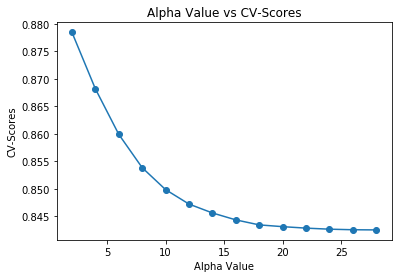

In [46]:
vect = CountVectorizer(binary=True)
x_train = vect.fit_transform(x_train)
x_test = vect.transform(x_test)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
alpha_optimum_bow = run_NB(x_train,y_train)
print("Optimal k value for BoW :" ,alpha_optimum_bow)

In [47]:
nb_bow = BernoulliNB(alpha=alpha_optimum_bow)

In [48]:
nb_bow.fit(x_train, y_train)

BernoulliNB(alpha=2, binarize=0.0, class_prior=None, fit_prior=True)

In [49]:
predict_bow = nb_bow.predict(x_test)

In [50]:
accuracy_bow = accuracy_score(y_test, predict_bow) * 100
print('\nThe accuracy of the knn classifier :' , accuracy_bow)


The accuracy of the knn classifier : 88.15948449456303


In [51]:
train_accuracy_bow = nb_bow.score(x_train, y_train)*100
print("Train accuracy :", train_accuracy_bow)

Train accuracy : 88.57323306618964


In [52]:
train_error_bow = 100-train_accuracy_bow
print("Train Error :", train_error_bow)

Train Error : 11.426766933810356


In [53]:
test_error_bow = 100-accuracy_bow
print("Test Error :" ,test_error_bow)

Test Error : 11.840515505436969


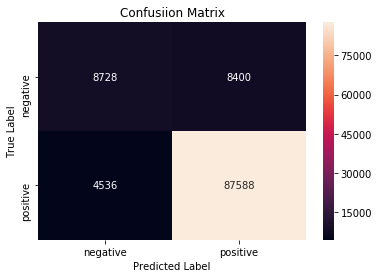

             precision    recall  f1-score   support

   negative       0.66      0.51      0.57     17128
   positive       0.91      0.95      0.93     92124

avg / total       0.87      0.88      0.88    109252



In [54]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predict_bow)

class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

from sklearn.metrics import classification_report
print(classification_report(y_test, predict_bow))

# 2.2 TF-IDF

In [55]:
x_train, x_test, y_train, y_test = train_test_split(final['CleanedText'], final['Score'], random_state = 0,test_size = 0.3)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(254919,) (109252,) (254919,) (109252,)


(254919, 2338152) (109252, 2338152) (254919,) (109252,)
For Alpha =  2 Accuracy Score =  0.8375013338919162
For Alpha =  4 Accuracy Score =  0.8410985434772729
For Alpha =  6 Accuracy Score =  0.842357766980793
For Alpha =  8 Accuracy Score =  0.8427147458730928
For Alpha =  10 Accuracy Score =  0.8429187323606495
For Alpha =  12 Accuracy Score =  0.8430246484037255
For Alpha =  14 Accuracy Score =  0.8430599526742226
For Alpha =  16 Accuracy Score =  0.8430913347609563
For Alpha =  18 Accuracy Score =  0.8431109489113817
For Alpha =  20 Accuracy Score =  0.8431305629079298
For Alpha =  22 Accuracy Score =  0.8431384091220829
For Alpha =  24 Accuracy Score =  0.8431384091220829
For Alpha =  26 Accuracy Score =  0.8431384089681935
For Alpha =  28 Accuracy Score =  0.8431501775200239
****************************************************************************************************


28

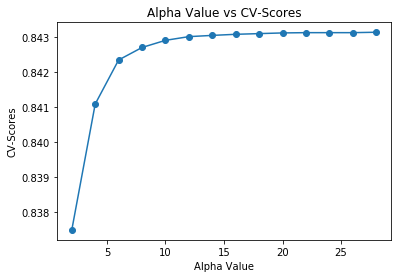

In [56]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),binary=True)
x_train = tf_idf_vect.fit_transform(x_train)
x_test = tf_idf_vect.transform(x_test)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
alpha_optimum_tfidf = run_NB(x_train, y_train)
alpha_optimum_tfidf

In [57]:
nb_tfidf = BernoulliNB(alpha=alpha_optimum_tfidf)

In [58]:
nb_tfidf.fit(x_train, y_train)

BernoulliNB(alpha=28, binarize=0.0, class_prior=None, fit_prior=True)

In [59]:
predict_tfidf = nb_tfidf.predict(x_test)

In [60]:
accuracy_tfidf = accuracy_score(y_test, predict_tfidf) * 100
print('\nThe accuracy of the knn classifier :' , accuracy_bow)


The accuracy of the knn classifier : 88.15948449456303


In [61]:
train_accuracy_tfidf = nb_tfidf.score(x_train, y_train)*100
print("Train accuracy :", train_accuracy_tfidf)

Train accuracy : 84.31423314856876


In [62]:
train_error_tfidf = 100-train_accuracy_tfidf
print("Train Error :", train_error_tfidf)

Train Error : 15.68576685143124


In [63]:
test_error_tfidf = 100-accuracy_tfidf
print("Test Error :" ,test_error_tfidf)

Test Error : 15.678431516127858


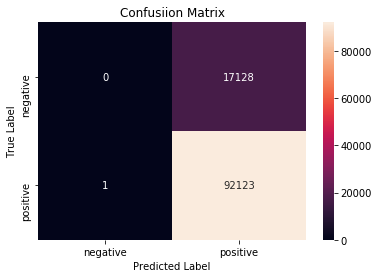

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00     17128
   positive       0.84      1.00      0.91     92124

avg / total       0.71      0.84      0.77    109252



In [64]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predict_tfidf)

class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

from sklearn.metrics import classification_report
print(classification_report(y_test, predict_tfidf))

# Comparasion Table for Bernoulli NB:

In [65]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model","Hyper parameter", "Accuracy" , "Train Error", "Test Error"]

x.add_row(["Bag Of Words",alpha_optimum_bow,accuracy_bow, train_error_bow , test_error_bow])
x.add_row(["TF-IDF",alpha_optimum_tfidf,accuracy_tfidf, train_error_tfidf , test_error_tfidf ])
print(x)

+--------------+-----------------+-------------------+--------------------+--------------------+
|    Model     | Hyper parameter |      Accuracy     |    Train Error     |     Test Error     |
+--------------+-----------------+-------------------+--------------------+--------------------+
| Bag Of Words |        2        | 88.15948449456303 | 11.426766933810356 | 11.840515505436969 |
|    TF-IDF    |        28       | 84.32156848387214 | 15.68576685143124  | 15.678431516127858 |
+--------------+-----------------+-------------------+--------------------+--------------------+


# 2.5 Conclusion:

1. Results of the above model may vary based on the number of samples considered. 
2. By comparing the results of all the above 4 models, acurracy is almost same for all the models, it is bit high for BOW i.e., 88% , hence we can use BOW for predicting the reviews.

# 3 Function for Navie Bayes using Nominal NB

# 3.1 BOW:

In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
def run_NB(X_Train,y_train):
    global Final_Metrics
    cv_scores = []
    k_value = []
    Train_Scores = []
    Test_Scores = []
    algo = 'Naive Bayes'
    j=0    
    for i in range(2,30,2):
        nb = MultinomialNB(alpha=i)
        scores = cross_val_score(nb, X_Train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())
        k_value.append(i)
        print('For Alpha = ', i,'Accuracy Score = ', cv_scores[j]) 
        j+=1
    alpha_optimum = k_value[cv_scores.index(max(cv_scores))]
    plt.plot(k_value,cv_scores,'-o')
    plt.xlabel('Alpha Value')
    plt.ylabel('CV-Scores')
    plt.title('Alpha Value vs CV-Scores')
    print('*' * 100)
    return alpha_optimum

In [67]:
x_train, x_test, y_train, y_test = train_test_split(final['CleanedText'], final['Score'], random_state = 0,test_size = 0.3)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(254919,) (109252,) (254919,) (109252,)


(254919, 60218)
(109252, 60218)
(254919,)
(109252,)
For Alpha =  2 Accuracy Score =  0.9050717864157782
For Alpha =  4 Accuracy Score =  0.8986226777241161
For Alpha =  6 Accuracy Score =  0.8869640784654239
For Alpha =  8 Accuracy Score =  0.8758115278579439
For Alpha =  10 Accuracy Score =  0.8669067392559711
For Alpha =  12 Accuracy Score =  0.8600339722393869
For Alpha =  14 Accuracy Score =  0.8551265333719794
For Alpha =  16 Accuracy Score =  0.8516823026494208
For Alpha =  18 Accuracy Score =  0.849183469946478
For Alpha =  20 Accuracy Score =  0.8474142806855657
For Alpha =  22 Accuracy Score =  0.846276661190594
For Alpha =  24 Accuracy Score =  0.8453547973506886
For Alpha =  26 Accuracy Score =  0.8447349944438169
For Alpha =  28 Accuracy Score =  0.8442564087727993
****************************************************************************************************
Optimal k value for BoW : 2


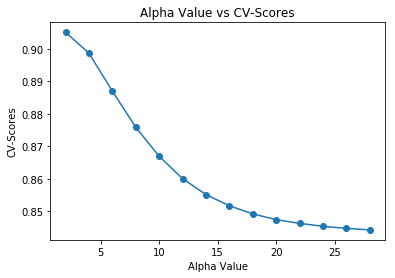

In [68]:
vect = CountVectorizer(binary=True)
x_train = vect.fit_transform(x_train)
x_test = vect.transform(x_test)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
alpha_optimum_bow = run_NB(x_train,y_train)
print("Optimal k value for BoW :" ,alpha_optimum_bow)

In [69]:
nb_bow = MultinomialNB(alpha=alpha_optimum_bow)
nb_bow.fit(x_train, y_train)
predict_bow = nb_bow.predict(x_test)
accuracy_bow = accuracy_score(y_test, predict_bow) * 100
print('\nThe accuracy of the knn classifier :' , accuracy_bow)
train_accuracy_bow = nb_bow.score(x_train, y_train)*100
print("Train accuracy :", train_accuracy_bow)
train_error_bow = 100-train_accuracy_bow
print("Train Error :", train_error_bow)
test_error_bow = 100-accuracy_bow
print("Test Error :" ,test_error_bow)


The accuracy of the knn classifier : 90.67385494087064
Train accuracy : 91.24192390524048
Train Error : 8.758076094759517
Test Error : 9.32614505912936


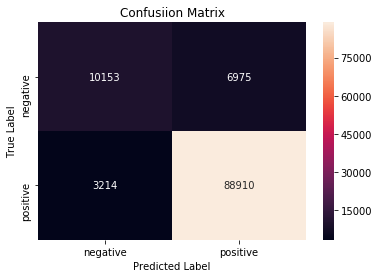

             precision    recall  f1-score   support

   negative       0.76      0.59      0.67     17128
   positive       0.93      0.97      0.95     92124

avg / total       0.90      0.91      0.90    109252



In [70]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predict_bow)

class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

from sklearn.metrics import classification_report
print(classification_report(y_test, predict_bow))

# 3.2 TF-IDF:

In [71]:
x_train, x_test, y_train, y_test = train_test_split(final['CleanedText'], final['Score'], random_state = 0,test_size = 0.3)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(254919,) (109252,) (254919,) (109252,)


(254919, 2338152) (109252, 2338152) (254919,) (109252,)
For Alpha =  2 Accuracy Score =  0.843161945456296
For Alpha =  4 Accuracy Score =  0.8431580229647533
For Alpha =  6 Accuracy Score =  0.8431580229647533
For Alpha =  8 Accuracy Score =  0.8431580229647533
For Alpha =  10 Accuracy Score =  0.8431580229647533
For Alpha =  12 Accuracy Score =  0.8431580229647533
For Alpha =  14 Accuracy Score =  0.8431580229647533
For Alpha =  16 Accuracy Score =  0.8431580229647533
For Alpha =  18 Accuracy Score =  0.8431580229647533
For Alpha =  20 Accuracy Score =  0.8431580229647533
For Alpha =  22 Accuracy Score =  0.8431580229647533
For Alpha =  24 Accuracy Score =  0.8431580229647533
For Alpha =  26 Accuracy Score =  0.8431580229647533
For Alpha =  28 Accuracy Score =  0.8431580229647533
****************************************************************************************************


2

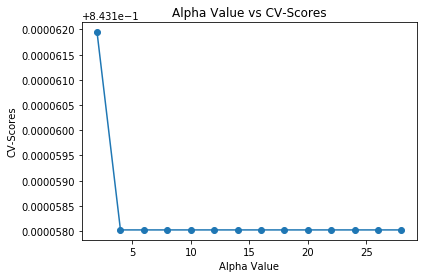

In [72]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),binary=True)
x_train = tf_idf_vect.fit_transform(x_train)
x_test = tf_idf_vect.transform(x_test)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
alpha_optimum_tfidf = run_NB(x_train, y_train)
alpha_optimum_tfidf

In [73]:
nb_tfidf = MultinomialNB(alpha=alpha_optimum_tfidf)
nb_tfidf.fit(x_train, y_train)
predict_tfidf = nb_tfidf.predict(x_test)
accuracy_tfidf = accuracy_score(y_test, predict_tfidf) * 100
print('\nThe accuracy of the knn classifier :' , accuracy_bow)
train_accuracy_tfidf = nb_tfidf.score(x_train, y_train)*100
print("Train accuracy :", train_accuracy_tfidf)
train_error_tfidf = 100-train_accuracy_tfidf
print("Train Error :", train_error_tfidf)
test_error_tfidf = 100-accuracy_tfidf
print("Test Error :" ,test_error_tfidf)


The accuracy of the knn classifier : 90.67385494087064
Train accuracy : 84.31815596326676
Train Error : 15.681844036733239
Test Error : 15.675685570973528


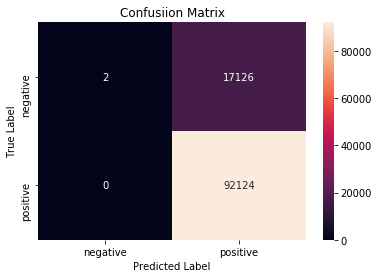

             precision    recall  f1-score   support

   negative       1.00      0.00      0.00     17128
   positive       0.84      1.00      0.91     92124

avg / total       0.87      0.84      0.77    109252



In [74]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predict_tfidf)

class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

from sklearn.metrics import classification_report
print(classification_report(y_test, predict_tfidf))

# Comparasion Table for Multinominal NB:

In [75]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model","Hyper parameter", "Accuracy" , "Train Error", "Test Error"]

x.add_row(["Bag Of Words",alpha_optimum_bow,accuracy_bow, train_error_bow , test_error_bow])
x.add_row(["TF-IDF",alpha_optimum_tfidf,accuracy_tfidf, train_error_tfidf , test_error_tfidf ])
print(x)

+--------------+-----------------+-------------------+--------------------+--------------------+
|    Model     | Hyper parameter |      Accuracy     |    Train Error     |     Test Error     |
+--------------+-----------------+-------------------+--------------------+--------------------+
| Bag Of Words |        2        | 90.67385494087064 | 8.758076094759517  |  9.32614505912936  |
|    TF-IDF    |        2        | 84.32431442902647 | 15.681844036733239 | 15.675685570973528 |
+--------------+-----------------+-------------------+--------------------+--------------------+


# 3.5 Conclusion:

1. Results of the above model may vary based on the number of samples considered. 
2. By comparing the results of all the above 4 models, acurracy is almost same for all the models, it is bit high for BOW i.e., 90% , hence we can use BOW for predicting the reviews.